In [318]:
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
import numpy as np
import bm,glm
from float_precision import curr_float,curr_int
import matplotlib.pyplot as plt
%matplotlib inline

<module 'regression' from '../source/regression.py'>

# Generate data from a pairwise Ising or Potts model

In [329]:
B = 50000
N = 10
n_c = 5
nature = 'Potts'
BM = bm.BM(N=N,n_c=n_c,nature=nature)

h  = 0.5 * np.squeeze(np.array(np.random.randn(N,n_c),dtype=curr_float ) )
J = 0.5 * np.squeeze(np.array(np.random.randn(N,N,n_c,n_c) ,dtype=curr_float ))
if n_c>1:
    J += np.swapaxes(np.swapaxes(J,0,1),2,3)
    J = np.asarray(J,order='c')
else:
    J += J.T
    J[np.arange(N),np.arange(N)] *=0

BM.layer.fields = h
BM.layer.couplings = J 

data = BM.gen_data(Nthermalize = 1000, Nstep=50,Nchains=10,Lchains=B//10)


# Perform pseudo-likelihood inference

In [340]:
if nature == 'Potts':
    diagonal_mask = np.zeros([N,N,n_c,n_c],dtype=curr_float)
    diagonal_mask[np.arange(N),np.arange(N),:,:] += 1
    all_mask = np.ones([N,N,n_c,n_c],dtype=curr_float)
else:
    diagonal_mask = np.eye(N,dtype=curr_float)
    all_mask = np.ones([N,N],dtype=curr_float)    
    
l2_plm = [('l2','weights',diagonal_mask * 10+all_mask * 0)]

# For predicting the pseudo-likelihood we formally regress each v_i against all v (including itself),
# but with a strong regularization in the diagonal J_{ii} so as to avoid using v_i.

GLM = glm.GLM(nature=nature,Nin=N,Nout=N,n_cin=n_c,n_cout=n_c)
GLM.fit(data,data,regularizers=l2_plm,learning_rate=5e-4,optimizer='ADAM',n_iter=10)

Starting epoch 1
Iteration 1, time = 0.91s, likelihood = -0.71, regularization  = 3.09e-03, loss = 0.72
Starting epoch 2
Iteration 2, time = 0.89s, likelihood = -0.70, regularization  = 2.55e-03, loss = 0.70
Starting epoch 3
Iteration 3, time = 0.90s, likelihood = -0.70, regularization  = 2.53e-03, loss = 0.70
Starting epoch 4
Iteration 4, time = 0.99s, likelihood = -0.69, regularization  = 2.66e-03, loss = 0.69
Starting epoch 5
Iteration 5, time = 1.05s, likelihood = -0.70, regularization  = 2.31e-03, loss = 0.70
Starting epoch 6
Iteration 6, time = 0.94s, likelihood = -0.69, regularization  = 2.50e-03, loss = 0.70
Starting epoch 7
Iteration 7, time = 1.01s, likelihood = -0.70, regularization  = 2.22e-03, loss = 0.70
Starting epoch 8
Iteration 8, time = 1.22s, likelihood = -0.70, regularization  = 2.28e-03, loss = 0.70
Starting epoch 9
Iteration 9, time = 1.42s, likelihood = -0.70, regularization  = 2.28e-03, loss = 0.70
Starting epoch 10
Iteration 10, time = 0.94s, likelihood = -0.69

'done'

# Compare couplings

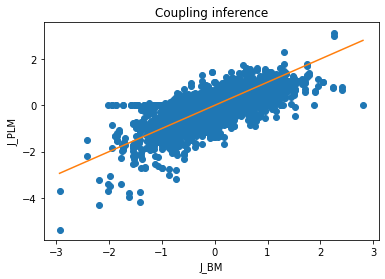

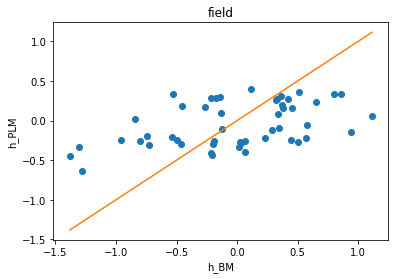

In [341]:
plt.scatter(J,GLM.weights);
plt.plot([J.min(),J.max()],[J.min(),J.max()],c='C1')
plt.xlabel('J_BM'); plt.ylabel('J_PLM');
plt.title('Coupling inference'); plt.show()

plt.scatter(h,GLM.output_layer.fields); 
plt.plot([h.min(),h.max()],[h.min(),h.max()],c='C1')
plt.xlabel('h_BM'); plt.ylabel('h_PLM');
plt.title('field'); plt.show()
